# Inversion of a sphere based on gravity response

This is a simple example for the probabilistic inversion of a classical geophysical example: the inversion of a sphere in the subsurface with a different density to the environment based on observed gravity data.

We start with the simplest possible case of only one observation (directly above the sphere) and only depth as an uncertain variable and then make the model progressively more complex.

In [18]:
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import edward2 as ed
tfd = tfp.distributions

import seaborn as sns
import pandas as pd
%matplotlib inline

tf.reset_default_graph()

np.random.seed(111)
# tf.set_random_seed(111)


We now calculate the effect of this density contrast that would be observed on the surface. This is a well-studied example with an analytical solution:

$$g(x) = 10^5 \;\frac{4}{3} \,\pi \;\frac{r^3 \,\Delta \rho\, G\, z}
{\sqrt{\left( x^2 + z^2\right)^3}}$$

where:

- $z$ is the vertical position of the center of the sphere (lateral position at origin),
- $r$ its radius,
- $\Delta \rho$ the density difference to the surrounding domain,
- $G$ the gravitational constant,
- and $x$ the position at which the gravitational acceleration is calculated.


In [19]:
def grav_analytical(x, sphere_center, sphere_radius, density_difference):
    """Calculate gravitational effect of a sphere, measured at surface
    
    **Arguments**:
    - 'x' = scalar or np.array: position(s) of observation
    - 'sphere_center' = float: is the vertical position of the center of the sphere (lateral position at origin)
    - 'sphere_radius' = float: sphere radius
    - 'density_difference' = float: density difference to the surrounding domain
    """
    G=6.67e-11 # gravitational constant
    return ((4/3)*np.pi * (sphere_radius**3) * density_difference
            * G * sphere_center/(x**2 + sphere_center**2)**(3/2)) * 1e5


## Geometric model

We consider here a sphere in the subsurface with a different density. 

spherical point mass

In [20]:
#True model

sphere_center_true = 300. #m 
density_difference_true = 500. # kg/m^3: density diffrence to surrounding domain
sphere_radius_true = 100. #m

truevalue_list = [sphere_center_true,density_difference_true,sphere_radius_true]
x_domain=np.linspace(-1000,1000,101) #m

In [21]:
x_obs = np.linspace(-250., 250., 11.)
grav_all = grav_analytical(x_domain, sphere_center_true, sphere_radius_true, density_difference_true)
grav_obs_array = grav_analytical(x_obs, sphere_center_true, sphere_radius_true, density_difference_true)
noise = norm(0,0.01).rvs(len(grav_obs_array))
grav_obs_array_withnoise = grav_obs_array +noise

/Users/zhouji/anaconda3/envs/Bayes/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  """Entry point for launching an IPython kernel.


In [22]:
grav_obs_array_withnoise

array([0.05903379, 0.09325413, 0.12603046, 0.12897358, 0.1410927 ,
       0.15062356, 0.14837635, 0.12898567, 0.10370969, 0.07757154,
       0.07276111])

Calculate the variance of the noise, put the variance in an noise tensor

In [23]:
noise_variance = np.std(noise)**2

noise_1 = tf.convert_to_tensor([noise_variance],dtype = tf.float32)
eye = tf.eye(x_obs.shape[0])
noise_tensor = tf.multiply(noise_1,eye)

Text(0, 0.5, 'Y [m]')

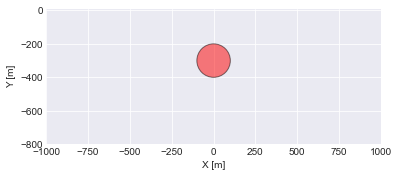

In [24]:
plt.style.use('seaborn-darkgrid')
ax = plt.subplot(aspect='equal') 

# create circle object as matplotlib patch
circle1 = plt.Circle((0, -sphere_center_true), sphere_radius_true, 
                     facecolor='r', edgecolor='k', alpha=0.5)

ax.add_artist(circle1)

# set model domain
ax.set_xlim([-1000,1000])
ax.set_ylim([-800,10])

ax.set_xlabel("X [m]")
ax.set_ylabel("Y [m]")


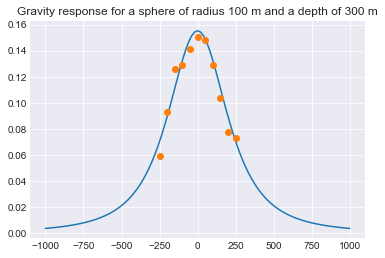

In [25]:
plt.plot(x_domain, grav_all)
plt.plot(x_obs, grav_obs_array_withnoise, 'o', label="data")
plt.title("Gravity response for a sphere of radius 100 m and a depth of 300 m");

### Algorithm Flowing hIPPYlib MCMC http://g2s3.com/labs/notebooks/SubsurfaceBayesian.html

Bayes’s Theorem

\begin{equation}
d \mu_{\mathrm{post}}\left(m | \mathbf{d}_{\mathrm{obs}}\right) \propto \pi_{\mathrm{like}}\left(\mathbf{d}_{\mathrm{obs}} | \mathrm{m}\right) \mathrm{d} \mu_{\mathrm{prior}}(\mathrm{m})
\end{equation}

Define the Prior
\begin{equation}
\mu_{\text {prior }} \sim \mathcal{N}\left(m_{\text {prior }}, C_{\text {prior }}\right)
\end{equation}

In [26]:
# sphere_center, density_difference, sphere_radius

mu_prior = [280., 480., 80.]


cov = [[ 100,  0.,  0.],
        [ 0.,  100, 0.],
        [ 0., 0.,  100]]


In [27]:
xvals =[]
norm_list =[]

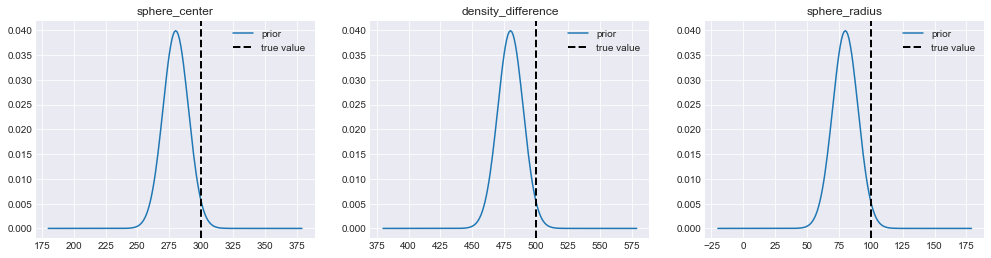

In [28]:
for i in range(3):
    xvals.append(np.arange(mu_prior[i]-100,mu_prior[i]+100))
    norm_list.append(norm.pdf(xvals[i],mu_prior[i],np.sqrt(cov[i][i])))
    
np.shape(xvals)

name_list = ["sphere_center", "density_difference", "sphere_radius"]

fig, axes = plt.subplots(1, 3, sharex='col', sharey='col')
fig.set_size_inches(17, 4)


for i in range(3):
    
    axes[i].plot(xvals[i], norm_list[i],label="prior")
    axes[i].title.set_text(name_list[i])
    axes[i].axvline(truevalue_list[i], label="true value", color='k', 
            linestyle='--', linewidth=2)
    axes[i].legend();

    

Define the Likelihood
\begin{equation}
\mathbf{d}_{\mathrm{obs}}=\mathbf{f}(\mathrm{m})+\mathbf{e}, \quad \mathbf{e} \sim \mathcal{N}\left(\mathbf{0}, \mathbf{\Gamma}_{\mathrm{noise}}\right)
\end{equation}
\begin{equation}
\pi_{\text {like }}\left(\mathbf{d}_{\text {obs }} | \mathrm{m}\right)=\exp \left(-\frac{1}{2}\left\|\mathbf{f}(\mathrm{m})-\mathbf{d}_{\text {obs }}\right\|_{\Gamma_{\text {noise }}^{-1}}^{2}\right)
\end{equation}

In [29]:
mu_prior = tf.convert_to_tensor(mu_prior)
cov = tf.convert_to_tensor(cov)


In [30]:
# Defind f(m). Here f is the parameter-to-observable map that takes a 
# parameter m and maps it to the space observation vector dobs.

def grav_analytical_tf(x, mu, cov,sess):
    # [sphere_center, density_difference, sphere_radius]

    mvn = ed.MultivariateNormalFullCovariance(
            loc = mu,
            covariance_matrix= cov)
    G=6.67e-11
    sphere_center = mvn.__getitem__(0)
    density_difference = mvn.__getitem__(1)
    sphere_radius = mvn.__getitem__(2)
    
    
    gravity = ((4/3)*np.pi * (sphere_radius**3) * density_difference* G 
               * sphere_center/(x**2 + sphere_center**2)**(3/2)) * 1e5 
    
#     print(sess.run(mvn))
    

    return gravity



### Gradient decent to find MAP (?)

In [31]:
## function compute G^T C^-1 G


def matrixcompute(matrix1,matrix2,Cov):
    matrix = tf.subtract(matrix1, matrix2)
    matrix = tf.reshape(matrix,[matrix.shape[0],1])
    matrix_T = tf.transpose(matrix)
    Cov_inv = tf.linalg.inv(Cov)
    result = tf.multiply(tf.constant(1/2),tf.matmul(tf.matmul(matrix_T,Cov_inv),matrix))
    return result

\begin{equation}
\pi_{\text {like }}\left(\mathbf{d}_{\text {obs }} | \mathrm{m}\right)=\exp \left(-\frac{1}{2}\left\|\mathbf{f}(\mathrm{m})-\mathbf{d}_{\text {obs }}\right\|_{\Gamma_{\text {noise }}^{-1}}^{2}\right)
\end{equation}

#### The posterior


\begin{equation}
d \mu_{\mathrm{post}}\left(m | \mathbf{d}_{\mathrm{obs}}\right) \propto \exp \left(-\frac{1}{2}\left\|\mathbf{f}(\mathrm{m})-\mathbf{d}_{\mathrm{obs}}\right\|_{\mathrm{\Gamma}_{\mathrm{noise}}^{-1}}^{2}-\frac{1}{2}\left\|\mathrm{m}-\mathrm{m}_{\mathrm{prior}}\right\|_{C_{\mathrm{prior}}^{-1}}^{2}\right)
\end{equation}

#### negative log of the posterior
\begin{equation}
\left(\frac{1}{2}\left\|\mathbf{f}(\mathrm{m})-\mathbf{d}_{\mathrm{obs}}\right\|_{\mathrm{\Gamma}_{\mathrm{noise}}^{-1}}^{2}+\frac{1}{2}\left\|\mathrm{m}-\mathrm{m}_{\mathrm{prior}}\right\|_{C_{\mathrm{prior}}^{-1}}^{2}\right)
\end{equation}


term 1 = 
\begin{equation}
\frac{1}{2}\left\|\mathbf{f}(\mathrm{m})-\mathbf{d}_{\text {obs }}\right\|_{\Gamma_{\text {noise }}^{-1}}^{2}
\end{equation}

term 2 =
\begin{equation}
\frac{1}{2}\left\|\mathrm{m}-\mathrm{m}_{\mathrm{prior}}\right\|_{C_{\mathrm{prior}}^{-1}}^{2}
\end{equation}


In [32]:
#     print(sess.run(tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)))

## initial guess

mu = tf.get_variable("mu", dtype=tf.float32,
  initializer=tf.constant([200., 400., 50.]))


In [33]:
def grav_analytical_tf_det(x, mu, cov,sess):
    # [sphere_center, density_difference, sphere_radius]

    G=6.67e-11
    sphere_center = mu[0]
    density_difference = mu[1]
    sphere_radius = mu[2]
    
    gravity = ((4/3)*np.pi * (sphere_radius**3) * density_difference* G 
               * sphere_center/(x**2 + sphere_center**2)**(3/2)) * 1e5 
    

    

    return gravity

In [34]:
init = tf.global_variables_initializer()
cost = []
with tf.Session() as session:
    session.run(init)
    grav = grav_analytical_tf_det(x_obs,mu, cov, session)
    term_1 = matrixcompute(grav,grav_obs_array_withnoise,noise_tensor)
    term_2 = matrixcompute(mu,mu_prior,cov)
    Negtive_log_likelihood = tf.add(term_1,term_2)
    
    
    optimizer = tf.train.GradientDescentOptimizer(0.1)
    train = optimizer.minimize(Negtive_log_likelihood,var_list =mu)
    log_tem = session.run(Negtive_log_likelihood) 
    
    
    print("starting at", "mu:", session.run(mu), "negative log likelihood:", session.run(Negtive_log_likelihood))
    for step in range(4000):  
        session.run(train)
        if step%100 == 0:print("step", step, "mu:", session.run(mu),"gradient:", session.run(tf.gradients(Negtive_log_likelihood,mu)))
        log_tem_new = session.run(Negtive_log_likelihood)
       ## Find and save MAP point 
        cost.append(log_tem_new[[0]])
        if step%100 == 0:print("negative log likelihood:",log_tem_new )
            
    MAP = session.run(mu)

W1018 11:31:10.963360 4597478848 deprecation.py:323] From /Users/zhouji/anaconda3/envs/Bayes/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1205: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


starting at mu: [200. 400.  50.] negative log likelihood: [[962.8329]]
step 0 mu: [199.77829  400.1845    52.538498] gradient: [array([  2.5568137,  -1.9640026, -26.915321 ], dtype=float32)]
negative log likelihood: [[895.5309]]
step 100 mu: [210.94853 409.64413  87.52889] gradient: [array([-1.4991555 , -0.7294161 , -0.28775737], dtype=float32)]
negative log likelihood: [[84.21236]]
step 200 mu: [224.12827 416.56848  89.96486] gradient: [array([-1.1553042 , -0.6562502 , -0.20505103], dtype=float32)]
negative log likelihood: [[61.37167]]
step 300 mu: [234.42218 422.8037   91.73265] gradient: [array([-0.91418684, -0.5914052 , -0.15150729], dtype=float32)]
negative log likelihood: [[46.53547]]
step 400 mu: [242.6432  428.42575  93.05482] gradient: [array([-0.7367188 , -0.5334984 , -0.11469726], dtype=float32)]
negative log likelihood: [[36.420395]]
step 500 mu: [249.31224 433.499    94.06422] gradient: [array([-0.601555 , -0.4815693, -0.0882998], dtype=float32)]
negative log likelihood: [

In [35]:
cost = np.reshape(cost,[4000])

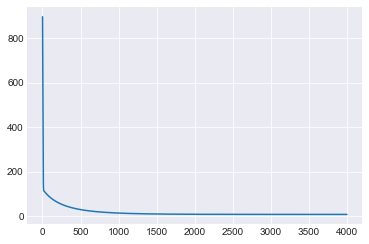

In [36]:
x = np.linspace(1,4000,4000)
plt.plot(x,cost)



Alternative Solution:
* Globalized Newtown-CG method as in hIPPYlib

## MCMC

In [37]:
# MAP = [300., 500., 100.]
MAP = tf.convert_to_tensor(MAP)

with tf.Session() as sess:

    print(sess.run(MAP))


[283.86972 479.7694   97.58056]


In [38]:
def compute_hessian(fn, vars):
    mat = []
    for v1 in vars:
        temp = []
        for v2 in vars:
            # computing derivative twice, first w.r.t v2 and then w.r.t v1
            temp.append(tf.gradients(tf.gradients(fn, v2)[0], v1)[0])
        temp = [cons(0) if t == None else t for t in temp] # tensorflow returns None when there is no gradient, so we replace None with 0
        temp = tf.stack(temp)
        mat.append(temp)
    mat = tf.stack(mat)
    return mat
def cons(x):
    return tf.constant(x, dtype=tf.float32)

### Forward model in TensorFlow

* Calculate Hessian
* Variable defined in Edward multivariate Normal object

In [39]:
def grav_analytical_tf(x, mu, cov, hess = False):
    # [sphere_center, density_difference, sphere_radius]

    mvn = ed.MultivariateNormalFullCovariance(
            loc = mu,
            covariance_matrix= cov)
    G=6.67e-11
    sphere_center = mvn.__getitem__(0)
    density_difference = mvn.__getitem__(1)
    sphere_radius = mvn.__getitem__(2)
    
    gravity = ((4/3)*np.pi * (sphere_radius**3) * density_difference* G 
           * sphere_center/(x**2 + sphere_center**2)**(3/2)) * 1e5 

    if hess == True:
        hess = compute_hessian(gravity,[sphere_center,density_difference,sphere_radius])
        return gravity, hess
    return gravity


#### Compute the Hessian and Covariance of the Posterior at MAP

\begin{equation}
\mathcal{C}_{\mathrm{post}}=\left(\mathcal{H}_{\mathrm{misfit}}\left(m_{\nu}\right)+\mathcal{C}_{\mathrm{prior}}^{-1}\right)^{-1}
\end{equation}

In [40]:
grav, hess = grav_analytical_tf(x_obs, MAP, cov, hess = True)


In [41]:
Matrix_tem = tf.add(hess, tf.linalg.inv(cov))

C_post = tf.linalg.inv(Matrix_tem)

In [42]:
with tf.Session() as session:
    print('hessian matrix at MAP: \n', session.run(hess))
    print('Covariance of the Prior: \n',session.run(cov))
    print('Covariance of the Posterior: \n',session.run(C_post))

hessian matrix at MAP: 
 [[ 5.4831660e-05 -1.4050618e-05 -2.1673014e-04]
 [-1.4050614e-05  0.0000000e+00  8.0128564e-05]
 [-2.1673014e-04  8.0128564e-05  8.2398643e-04]]
Covariance of the Prior: 
 [[100.   0.   0.]
 [  0. 100.   0.]
 [  0.   0. 100.]]
Covariance of the Posterior: 
 [[ 99.61377      0.10235681   1.640053  ]
 [  0.10235681 100.00465     -0.6493909 ]
 [  1.6400534   -0.6493909   93.323784  ]]


#### define whether to accept or reject the new sample
\begin{equation}
\Phi\left(m, \mathbf{d}_{\mathrm{obs}}\right)=\frac{1}{2}\left\|\mathbf{f}(\mathrm{m})-\mathbf{d}_{\mathrm{obs}}\right\|_{\Gamma_{\mathrm{noise}}^{-1}}
\end{equation}

\begin{equation}
a\left(m_{\text {current }}, m_{\text {proposed }}\right) :=\min \left\{1, \exp \left(\Phi\left(m_{\text {current }}, \mathbf{d}_{\text {obs }}\right)-\Phi\left(\mathrm{m}_{\text {proposed }}, \mathbf{d}_{\text {obs }}\right)\right)\right\}
\end{equation}

### preconditioned Crank-Nicolson proposal

In [43]:

@tf.function
def acceptance_pCN(m_current , m_proposed):
    
    grav_current = grav_analytical_tf(x_obs,m_current, cov)
    phi_current = matrixcompute(grav_current,grav_obs_array_withnoise,noise_tensor)

    grav_proposed = grav_analytical_tf(x_obs,m_proposed, cov)
    phi_proposed = matrixcompute(grav_proposed,grav_obs_array_withnoise,noise_tensor)


    ## calculate accept ratio if exp()<1
    accept_ratio = tf.exp(tf.subtract(phi_current,phi_proposed))
    acceptsample = tfd.Sample(
    tfd.Uniform(0., 1.),
    sample_shape=[1,1])
    sample = acceptsample.sample()
    
    ## greater : further away from the observation = less possible to accept
    then_expression = tf.greater_equal( phi_current,phi_proposed)
    else_expression = tf.greater(accept_ratio, sample)
    
    
    condition = tf.reshape(tf.greater_equal( phi_current,phi_proposed),())
    
    
    x = tf.cond(condition ,
               lambda: then_expression,
               lambda: else_expression)
    
    x = tf.reshape(x,())
    return x
        



#### gpCN

gpCN is a generalized version of the pCN sampler. While the proposals of pCN are drown from the prior Gaussian distribution $\mu_{prior}$,proposals in the generalized pCN are drown from a Gaussian approximation $v$ of the posterior distribution.

\begin{equation}
a_{\nu}\left(m_{\mathrm{current}}, m_{\mathrm{proposed}}\right) :=\min \left\{1, \exp \left(\Delta\left(m_{\mathrm{current}}\right)-\Delta\left(m_{\mathrm{proposed}}\right)\right)\right\}
\end{equation}

where   

\begin{equation}
\Delta(m)=\Phi\left(m, \mathbf{d}_{\mathrm{obs}}\right)+\frac{1}{2}\left\|\mathrm{m}-\mathrm{m}_{\mathrm{prior}}\right\|_{C_{\mathrm{prior}}^{-1}}^{2}-\frac{1}{2}\left\|\mathrm{m}-\mathrm{m}_{\nu}\right\|_{\mathrm{C}_{\nu}^{-1}}^{2}
\end{equation}

In [44]:

@tf.function
def acceptance_gpCN(m_current , m_proposed):
    
    grav_current = grav_analytical_tf(x_obs,m_current, cov)
    phi_current = matrixcompute(grav_current,grav_obs_array_withnoise,noise_tensor)
    # assign a name
    phi_current = tf.identity(phi_current, name="phi_current")
    
    grav_proposed = grav_analytical_tf(x_obs,m_proposed, cov)
    phi_proposed = matrixcompute(grav_proposed,grav_obs_array_withnoise,noise_tensor)
    # assign a name
    phi_proposed = tf.identity(phi_proposed, name="phi_proposed")

    t2_current = matrixcompute(m_current,mu_prior,cov)
    t3_current = matrixcompute(m_current,MAP,C_post)

    t2_proposed = matrixcompute(m_proposed,mu_prior,cov)
    t3_proposed = matrixcompute(m_proposed,MAP,C_post)

    delta_current = tf.subtract(tf.add(phi_current,t2_current ),t3_current)
    delta_proposed = tf.subtract(tf.add(phi_proposed,t2_proposed ),t3_proposed)

    ## calculate accept ratio if exp()<1
    accept_ratio = tf.exp(tf.subtract(delta_current,delta_proposed))
    acceptsample = tfd.Sample(
    tfd.Uniform(0., 1.),
    sample_shape=[1,1])
    sample = acceptsample.sample()
    
    
    ## greater : further away from the observation = less possible to accept
    then_expression = tf.greater_equal( delta_current,delta_proposed)
    else_expression = tf.greater(accept_ratio, sample,name = 'shit')
    
    condition = tf.reshape(tf.greater_equal( delta_current,delta_proposed)[0],())
    

    x = tf.cond(condition ,
               lambda: then_expression,
               lambda: else_expression)
    
    x = tf.reshape(x,())
    return x
        

#### Proposal

\begin{equation}
v^{(k)}=m_{\nu}+\sqrt{1-\beta^{2}}\left(m^{(k)}-m_{\nu}\right)+\beta \xi^{(k)}, \quad \xi^{(k)} \sim \mathcal{N}\left(0, \mathcal{C}_{\nu}\right)
\end{equation}

In [45]:
from IPython.display import clear_output
# define leaning rate
beta = 0.6

@tf.function
def draw_proposal(m_current):
    
    _term1 = MAP
    
    ## sqrt term
    tem_1 = tf.convert_to_tensor(np.sqrt(1-beta**2),dtype = tf.float32)
    ## sqrt(1-beta^2)()
    _term2 = tf.multiply(tem_1,(tf.subtract(m_current,MAP)))
    
    Xi = tfd.MultivariateNormalFullCovariance(
            loc = 0,
            covariance_matrix= C_post)

    Xi_s = tfd.Sample(Xi)
    _term3 = tf.multiply(beta,Xi_s.sample())
    
    m_proposed = tf.add(MAP,tf.add(_term2,_term3))
    
    return m_proposed
    

    

### Chain

In [55]:
def run_chain(sess):
    burn_in = 100
    steps = 1000
    k = 0
    accepted = []
    rejected = []

    m_current = mu  # init m
    
    
    for k in range(steps+burn_in):

        m_proposed = draw_proposal(m_current)
        
        if k%20 == 0: 
            clear_output();
            print(k, "finised")
        
## Check each proposal
#         print(sess.run(m_current))
#         print(sess.run(m_proposed))
#         print(sess.run(acceptance_gpCN(m_current,m_proposed)))
        if sess.run(acceptance_gpCN(m_current,m_proposed)):
            m_current = m_proposed
            if k > burn_in:
                accepted.append(m_proposed)
        else:
            m_current = m_current
            rejected.append(m_proposed)
    
    return accepted,rejected
    


In [56]:
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    accepted,rejected = sess.run(run_chain(sess))
    

1080 finised


In [ ]:
np.shape(accepted)[0]

In [57]:
def plot_trace(accepted):
            
    sphere_center_accepted = []
    density_difference_accepted = []
    sphere_radius_accepted = []
    for i in range(np.shape(accepted)[0]):
        
        sphere_center_accepted.append(accepted[i][0])
        density_difference_accepted.append(accepted[i][1])
        sphere_radius_accepted.append(accepted[i][2])
        
        
    fig, axes = plt.subplots(1, 3, sharex='col', sharey='col')
    fig.set_size_inches(17, 4)
    
    axes[0].hist(sphere_center_accepted,40,density=True)
    axes[1].hist(density_difference_accepted,40,density=True)
    axes[2].hist(sphere_radius_accepted,40,density=True)


    ## print prior
    for i in range(3):

        axes[i].plot(xvals[i], norm_list[i],label="prior")
        axes[i].title.set_text(name_list[i])
        axes[i].axvline(truevalue_list[i], label="true value", color='k', 
                linestyle='--', linewidth=2)
        axes[i].legend();


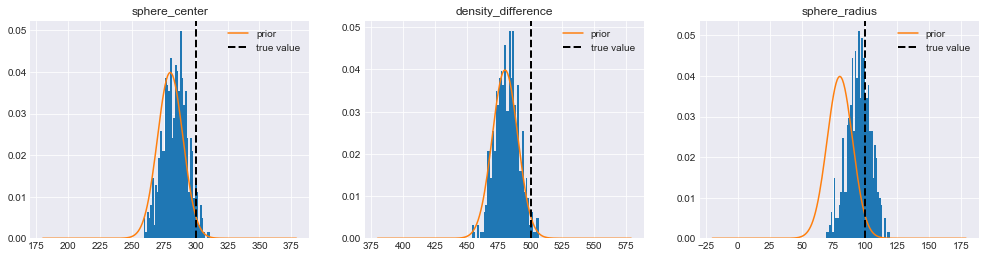

In [58]:
plot_trace(accepted)

In [59]:
import corner 

In [61]:
accepted

[array([286.7744  , 486.5578  , 102.539055], dtype=float32),
 array([288.0812 , 489.10614,  95.12447], dtype=float32),
 array([277.72598, 487.0849 , 101.89507], dtype=float32),
 array([282.61557, 492.55167, 102.56999], dtype=float32),
 array([280.8309 , 490.6332 ,  99.52235], dtype=float32),
 array([288.51666, 472.6367 , 109.71706], dtype=float32),
 array([283.0486 , 471.63193, 109.5942 ], dtype=float32),
 array([286.2341 , 477.5487 , 104.78345], dtype=float32),
 array([288.748  , 471.1024 , 111.24735], dtype=float32),
 array([292.4584 , 467.8856 , 110.84222], dtype=float32),
 array([298.77112, 482.66705, 103.29578], dtype=float32),
 array([291.04068, 490.60468,  96.05818], dtype=float32),
 array([292.4015 , 486.19113,  96.82536], dtype=float32),
 array([278.5639  , 486.83395 , 102.589455], dtype=float32),
 array([275.44247, 490.15326, 108.99596], dtype=float32),
 array([275.88547, 500.18457, 103.13397], dtype=float32),
 array([271.22324, 495.49036,  97.45579], dtype=float32),
 array([

W1018 16:24:35.402163 4597478848 corner.py:542] Too few points to create valid contours


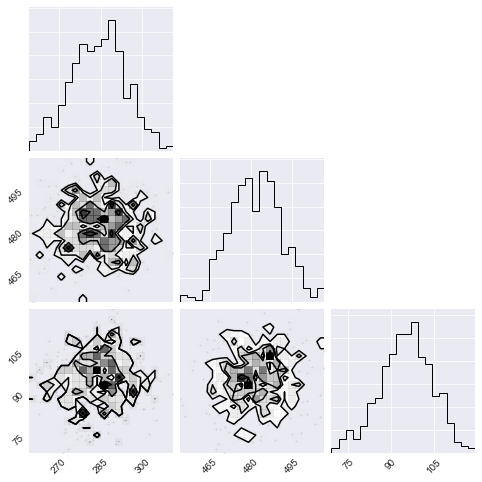

In [60]:
figure = corner.corner(accepted)

In [2]:
import multiprocessing as mp
print("Number of processors: ", mp.cpu_count())

Number of processors:  8


In [ ]:
pool = mp.Pool(mp.cpu_count())
